# Interactive Learning Course
## HW #2, Multi-Armed Bandits

In [96]:
import numpy as np
from abc import ABC, abstractmethod
import gym
import matplotlib.pyplot as plt

# Part 2

## Reward class

In [97]:
class Reward(ABC):
    def __init__(self, debts=[5, 20, 100]):
        super(Reward, self).__init__()
        self.debts = debts
        
    @abstractmethod
    def get_reward(self, action):
        pass

In [98]:
class Student(Reward):
    def __init__(self):
        super(Student, self).__init__()
        self.action_rewards=[]
        self.action_rewards.append((4*0.2+5*0.2+5.1*0.6) - 5)
        self.action_rewards.append((5*0.5+10*0.3+20*0.1+20.75*0.1) - 20)
        self.action_rewards.append((10*0.5+20*0.3+50*0.1+100*0.05+105*0.05) - 100)
        self.best_reward =max(self.action_rewards)
    def get_reward(self, action):
        if action == 0:
            obs = np.random.choice([4, 5, 5.1], p=[0.2, 0.2, 0.6])
        elif action == 1:
            obs = np.random.choice([5, 10, 20, 20.75], p=[0.5, 0.3, 0.1, 0.1])
        else:
            obs = np.random.choice([10, 20, 50, 100, 105], p=[0.5, 0.3, 0.1, 0.05, 0.05])
        
        return obs, obs - self.debts[action]

In [99]:
class GovStaff(Reward):
    def __init__(self):
        super(GovStaff, self).__init__()
        self.action_rewards=[]
        self.action_rewards.append((4*0.05+5*0.3+5.1*0.65) - 5)
        self.action_rewards.append((5*0.1+10*0.1+20*0.3+20.75*0.5)-20)
        self.action_rewards.append((20*0.1+50*0.1+80*0.2+100*0.3+105*0.3)-100)
        self.best_reward =max(self.action_rewards)

    def get_reward(self, action):
        if action == 0:
            obs = np.random.choice([4, 5, 5.1], p=[0.05, 0.3, 0.65])
        elif action == 1:
            obs = np.random.choice([5, 10, 20, 20.75], p=[0.1, 0.1, 0.3, 0.5])
        else:
            obs = np.random.choice([20, 50, 80, 100, 105], p=[0.1, 0.1, 0.2, 0.3, 0.3])
        
        return obs, obs - self.debts[action]

In [100]:
class SelfEmp(Reward):
    def __init__(self):
        super(SelfEmp, self).__init__()
        self.action_rewards=[]
        self.action_rewards.append((0*0.8+2.5*0.1+5.1*0.1)-5)
        self.action_rewards.append((5*0.05+10*0.05+20*0.3+20.75*0.6)-20)
        self.action_rewards.append((20*0.02+50*0.03+80*0.05+100*0.2+105*0.7)-100)
        self.best_reward =max(self.action_rewards)

    def get_reward(self, action):
        if action == 0:
            obs = np.random.choice([0, 2.5, 5.1], p=[0.8, 0.1, 0.1])
        elif action == 1:
            obs = np.random.choice([5, 10, 20, 20.75], p=[0.05, 0.05, 0.3, 0.6])
        else:
            obs = np.random.choice([20, 50, 80, 100, 105], p=[0.02, 0.03, 0.05, 0.2, 0.7])
        
        return obs, obs - self.debts[action]

## Environment

In [101]:
class Environment:
    def __init__(self, reward,id=None):
        self.reward = reward
        self.available_actions=[0,1,2]
        self.action_rewards=reward.action_rewards
    
    def calc_reward(self, action):
        return self.reward.get_reward(action)

    def get_available_actions(self):
        return self.available_actions

# Part 3

In [102]:
class Agent:
    def __init__(self, _id, env, alpha=0, beta=1, gamma=1):
        self.env=env
        self.alpha=alpha
        self.beta=beta
        self.gamma=gamma
        self.values=np.zeros(3)
        self.rewards=[]
        self.regrets=[]
        self.N = np.zeros(3)
        self.action_rewards = env.action_rewards

    @abstractmethod
    def choose_action(self):
        pass
    
    def calculate_utility(self, reward):
        utility = self.beta*reward**self.gamma + self.alpha
        return utility
    
    def take_action(self, action):
        reward = self.env.calc_reward(action)
        return reward

    def update_value(self, action, util):
        self.values[action] = self.values[action] + (1.0 / self.N[action] * (util - self.values[action]))
    @abstractmethod
    def step(self, best_reward, trial):
        pass

    def reset(self):
        self.values=np.zeros(3)
        self.rewards=[]
        self.regrets=[]
        self.N = np.zeros(3)

    
    def get_rewards(self):
        return self.rewards
    
    def get_regrets(self):
        return self.regrets

In [103]:
class epsilon(Agent):
    def __init__(self,env, _id=None, alpha=0, beta=1, gamma=1,eps=0.2):
        super().__init__(_id, env, alpha, beta, gamma)
        self.eps=eps
    def choose_action(self):
        actions=self.env.get_available_actions()
        greedy_action=np.argmax(self.values)
        if np.random.random() > self.eps:
            action = greedy_action
        else:
            action = np.random.choice(actions)

        self.N[action]+=1
        return action
    def step(self, best_reward, trial):
        action = self.choose_action()
        reward = self.take_action(action)[1]
        utility=self.calculate_utility(reward)
        self.update_value(action,utility)
        self.rewards.append(reward)
        self.regrets.append(best_reward - self.action_rewards[action])
        

In [104]:
class gradient(Agent):
    def __init__(self,env, _id=None, alpha=0, beta=1, gamma=1,h=[0,0,0],learning_rate=1e-3):
        super().__init__(_id, env, alpha, beta, gamma)
        self.h=h
        self.learning_rate=learning_rate
    def choose_action(self):
        actions = self.env.get_available_actions()
        prob = np.exp(self.h- np.max(self.h)) / sum(np.exp(self.h- np.max(self.h)))
        action = np.random.choice(a=actions,p=prob)
        self.N[action]+=1
        return action,prob
    def step(self, best_reward, trial):
        action,prob= self.choose_action()
        reward = self.take_action(action)[1]
        utility=self.calculate_utility(reward)
        self.update_value(action,utility)
        actions = self.env.get_available_actions()
        for i in actions:
            if i != action:
                self.h[i]-= self.learning_rate * (utility - self.values[action])*prob[i]
            else:
                self.h[i]+= self.learning_rate * (utility - self.values[action])*(1-prob[i])
        self.rewards.append(reward)
        self.regrets.append(best_reward - self.action_rewards[action])

In [105]:
class ucb(Agent):
    def __init__(self,env, _id=None, alpha=0, beta=1, gamma=1,c=2):
        super().__init__(_id, env, alpha, beta, gamma)
        self.c = c
    def choose_action(self,trial):
        ucb = []
        for i in range(3):
            if self.N[i] > 0:
                u=self.values[i] + self.c * np.sqrt((2* np.log(trial)) / self.N[i])
            else:
                u=1e500
            ucb.append(u)
        action = np.argmax(ucb)
        self.N[action]+=1
        return action
    def step(self, best_reward, trial):
        action = self.choose_action(trial)
        reward = self.take_action(action)[1]
        utility=self.calculate_utility(reward)
        self.update_value(action,utility)
        self.rewards.append(reward)
        self.regrets.append(best_reward - self.action_rewards[action])

# Part 4:

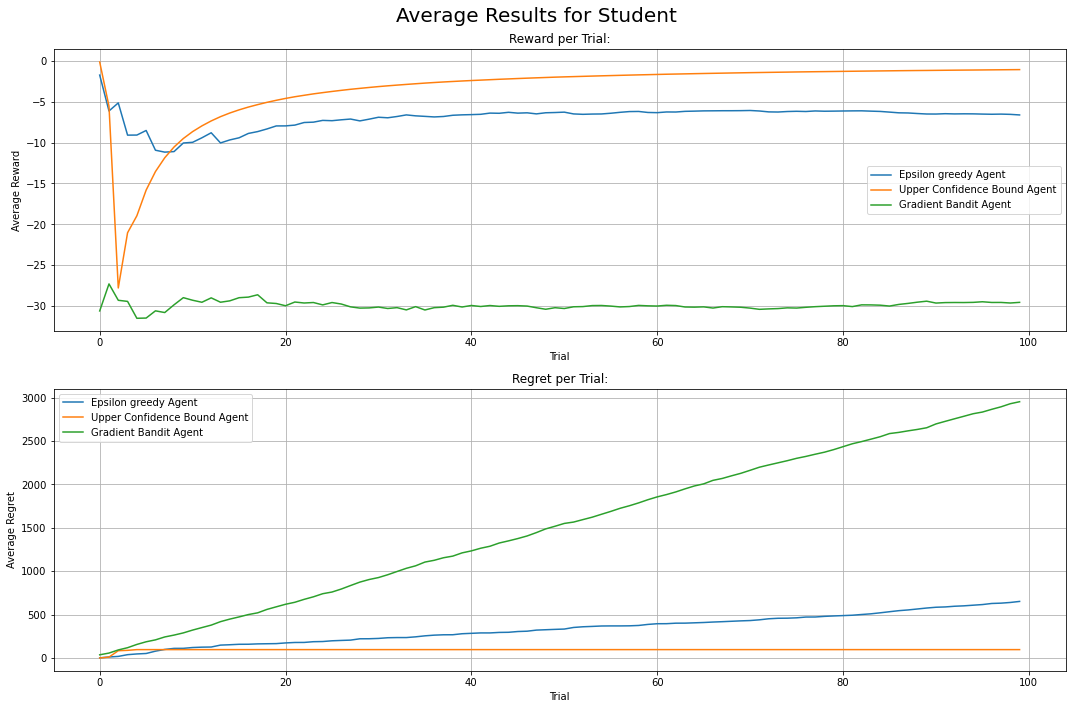

In [106]:
reward=Student()
env = Environment(reward=reward)
agent =epsilon(env=env)
rewards=[]
regrets=[]
for j in range(20):
    agent.reset()
    for i in range(1,101):
        agent.step(reward.best_reward,trial=i)
    rewards.append(np.cumsum(agent.get_rewards())/np.arange(1,101))
    regrets.append(np.cumsum(agent.get_regrets()))

rewards=np.stack([i for i in rewards],axis=1)
regrets=np.stack([i for i in regrets],axis=1)
epsilon_average_reward=rewards.mean(axis=1)
epsilon_average_regret=regrets.mean(axis=1)


agent =ucb(env=env)
rewards=[]
regrets=[]
for j in range(20):
    agent.reset()
    for i in range(1,101):
        agent.step(reward.best_reward,trial=i)
    rewards.append(np.cumsum(agent.get_rewards())/np.arange(1,101))
    regrets.append(np.cumsum(agent.get_regrets()))

rewards=np.stack([i for i in rewards],axis=1)
regrets=np.stack([i for i in regrets],axis=1)
ucb_average_reward=rewards.mean(axis=1)
ucb_average_regret=regrets.mean(axis=1)


agent =gradient(env=env)
rewards=[]
regrets=[]
for j in range(20):
    agent.reset()
    for i in range(1,101):
        agent.step(reward.best_reward,trial=i)
    rewards.append(np.cumsum(agent.get_rewards())/np.arange(1,101))
    regrets.append(np.cumsum(agent.get_regrets()))

rewards=np.stack([i for i in rewards],axis=1)
regrets=np.stack([i for i in regrets],axis=1)
gradient_average_reward=rewards.mean(axis=1)
gradient_average_regret=regrets.mean(axis=1)

fig,axs=plt.subplots(nrows=2,ncols=1,figsize=(15,10))
plt.suptitle("Average Results for Student",size=20)

axs[0].set_title('Reward per Trial:')
axs[0].set_ylabel("Average Reward")
axs[0].set_xlabel("Trial")
axs[0].grid()
axs[0].plot(epsilon_average_reward,label='Epsilon greedy Agent')
axs[0].plot(ucb_average_reward,label='Upper Confidence Bound Agent')
axs[0].plot(gradient_average_reward,label='Gradient Bandit Agent')

axs[1].set_title('Regret per Trial:')
axs[1].set_ylabel("Average Regret")
axs[1].set_xlabel("Trial")
axs[1].grid()
axs[1].plot(epsilon_average_regret,label='Epsilon greedy Agent')
axs[1].plot(ucb_average_regret,label='Upper Confidence Bound Agent')
axs[1].plot(gradient_average_regret,label='Gradient Bandit Agent')
axs[0].legend()
axs[1].legend()
fig.tight_layout()
plt.show()

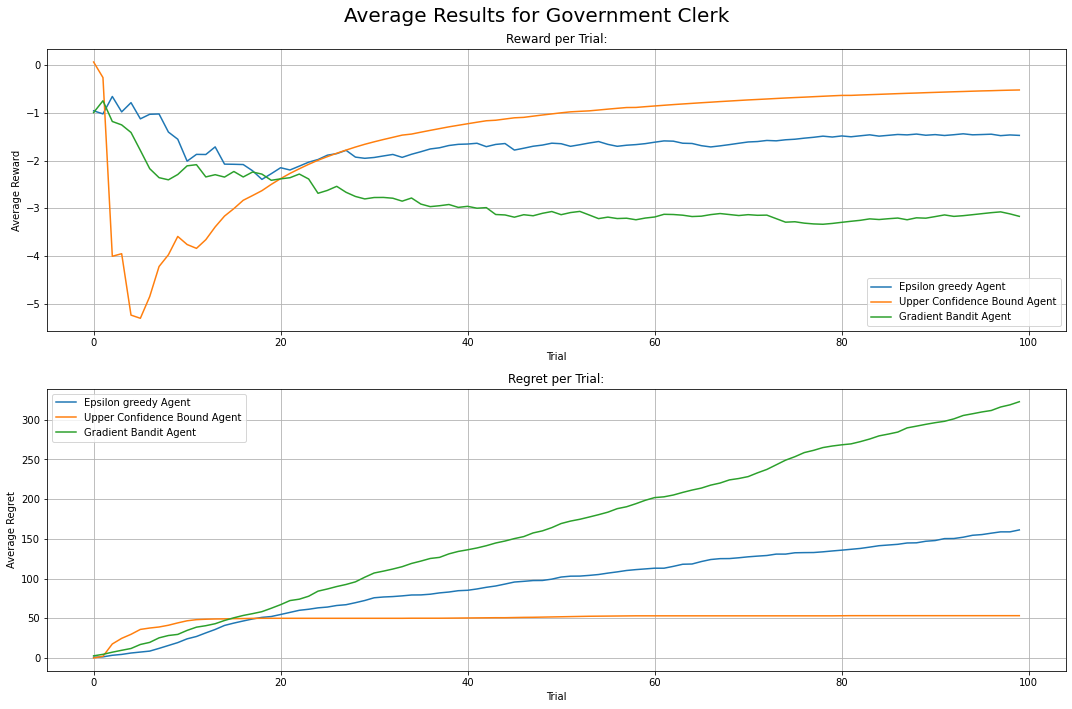

In [107]:
reward=GovStaff()
env = Environment(reward=reward)
agent =epsilon(env=env)
rewards=[]
regrets=[]
for j in range(20):
    agent.reset()
    for i in range(1,101):
        agent.step(reward.best_reward,trial=i)
    rewards.append(np.cumsum(agent.get_rewards())/np.arange(1,101))
    regrets.append(np.cumsum(agent.get_regrets()))

rewards=np.stack([i for i in rewards],axis=1)
regrets=np.stack([i for i in regrets],axis=1)
epsilon_average_reward=rewards.mean(axis=1)
epsilon_average_regret=regrets.mean(axis=1)

agent =ucb(env=env)
rewards=[]
regrets=[]
for j in range(20):
    agent.reset()
    for i in range(1,101):
        agent.step(reward.best_reward,trial=i)
    rewards.append(np.cumsum(agent.get_rewards())/np.arange(1,101))
    regrets.append(np.cumsum(agent.get_regrets()))

rewards=np.stack([i for i in rewards],axis=1)
regrets=np.stack([i for i in regrets],axis=1)
ucb_average_reward=rewards.mean(axis=1)
ucb_average_regret=regrets.mean(axis=1)


agent =gradient(env=env)
rewards=[]
regrets=[]
for j in range(20):
    agent.reset()
    for i in range(1,101):
        agent.step(reward.best_reward,trial=i)
    rewards.append(np.cumsum(agent.get_rewards())/np.arange(1,101))
    regrets.append(np.cumsum(agent.get_regrets()))

rewards=np.stack([i for i in rewards],axis=1)
regrets=np.stack([i for i in regrets],axis=1)
gradient_average_reward=rewards.mean(axis=1)
gradient_average_regret=regrets.mean(axis=1)

fig,axs=plt.subplots(nrows=2,ncols=1,figsize=(15,10))
plt.suptitle("Average Results for Government Clerk",size=20)

axs[0].set_title('Reward per Trial:')
axs[0].set_ylabel("Average Reward")
axs[0].set_xlabel("Trial")
axs[0].grid()
axs[0].plot(epsilon_average_reward,label='Epsilon greedy Agent')
axs[0].plot(ucb_average_reward,label='Upper Confidence Bound Agent')
axs[0].plot(gradient_average_reward,label='Gradient Bandit Agent')

axs[1].set_title('Regret per Trial:')
axs[1].set_ylabel("Average Regret")
axs[1].set_xlabel("Trial")
axs[1].grid()
axs[1].plot(epsilon_average_regret,label='Epsilon greedy Agent')
axs[1].plot(ucb_average_regret,label='Upper Confidence Bound Agent')
axs[1].plot(gradient_average_regret,label='Gradient Bandit Agent')
axs[0].legend()
axs[1].legend()
fig.tight_layout()
plt.show()

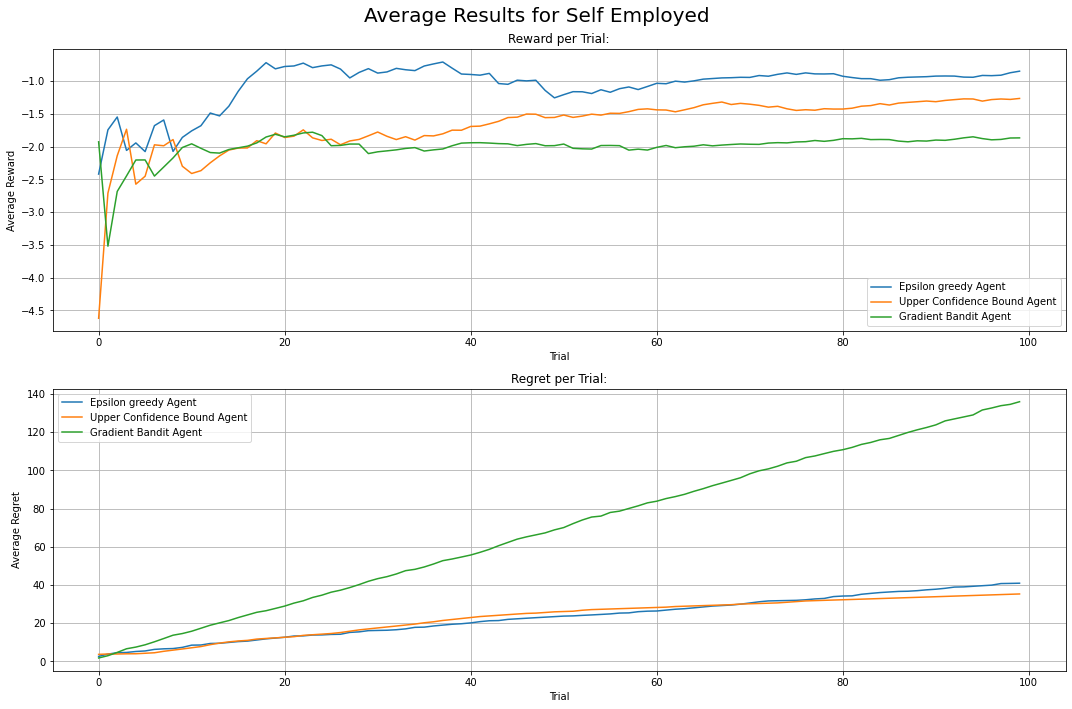

In [108]:
reward=SelfEmp()
env = Environment(reward=reward)
agent =epsilon(env=env)
rewards=[]
regrets=[]
for j in range(20):
    agent.reset()
    for i in range(1,101):
        agent.step(reward.best_reward,trial=i)
    rewards.append(np.cumsum(agent.get_rewards())/np.arange(1,101))
    regrets.append(np.cumsum(agent.get_regrets()))

rewards=np.stack([i for i in rewards],axis=1)
regrets=np.stack([i for i in regrets],axis=1)
epsilon_average_reward=rewards.mean(axis=1)
epsilon_average_regret=regrets.mean(axis=1)

agent =ucb(env=env)
rewards=[]
regrets=[]
for j in range(20):
    agent.reset()
    for i in range(1,101):
        agent.step(reward.best_reward,trial=i)
    rewards.append(np.cumsum(agent.get_rewards())/np.arange(1,101))
    regrets.append(np.cumsum(agent.get_regrets()))

rewards=np.stack([i for i in rewards],axis=1)
regrets=np.stack([i for i in regrets],axis=1)
ucb_average_reward=rewards.mean(axis=1)
ucb_average_regret=regrets.mean(axis=1)


agent =gradient(env=env)
rewards=[]
regrets=[]
for j in range(20):
    agent.reset()
    for i in range(1,101):
        agent.step(reward.best_reward,trial=i)
    rewards.append(np.cumsum(agent.get_rewards())/np.arange(1,101))
    regrets.append(np.cumsum(agent.get_regrets()))

rewards=np.stack([i for i in rewards],axis=1)
regrets=np.stack([i for i in regrets],axis=1)
gradient_average_reward=rewards.mean(axis=1)
gradient_average_regret=regrets.mean(axis=1)

fig,axs=plt.subplots(nrows=2,ncols=1,figsize=(15,10))
plt.suptitle("Average Results for Self Employed",size=20)

axs[0].set_title('Reward per Trial:')
axs[0].set_ylabel("Average Reward")
axs[0].set_xlabel("Trial")
axs[0].grid()
axs[0].plot(epsilon_average_reward,label='Epsilon greedy Agent')
axs[0].plot(ucb_average_reward,label='Upper Confidence Bound Agent')
axs[0].plot(gradient_average_reward,label='Gradient Bandit Agent')

axs[1].set_title('Regret per Trial:')
axs[1].set_ylabel("Average Regret")
axs[1].set_xlabel("Trial")
axs[1].grid()
axs[1].plot(epsilon_average_regret,label='Epsilon greedy Agent')
axs[1].plot(ucb_average_regret,label='Upper Confidence Bound Agent')
axs[1].plot(gradient_average_regret,label='Gradient Bandit Agent')
axs[0].legend()
axs[1].legend()
fig.tight_layout()
plt.show()

# Part 5:

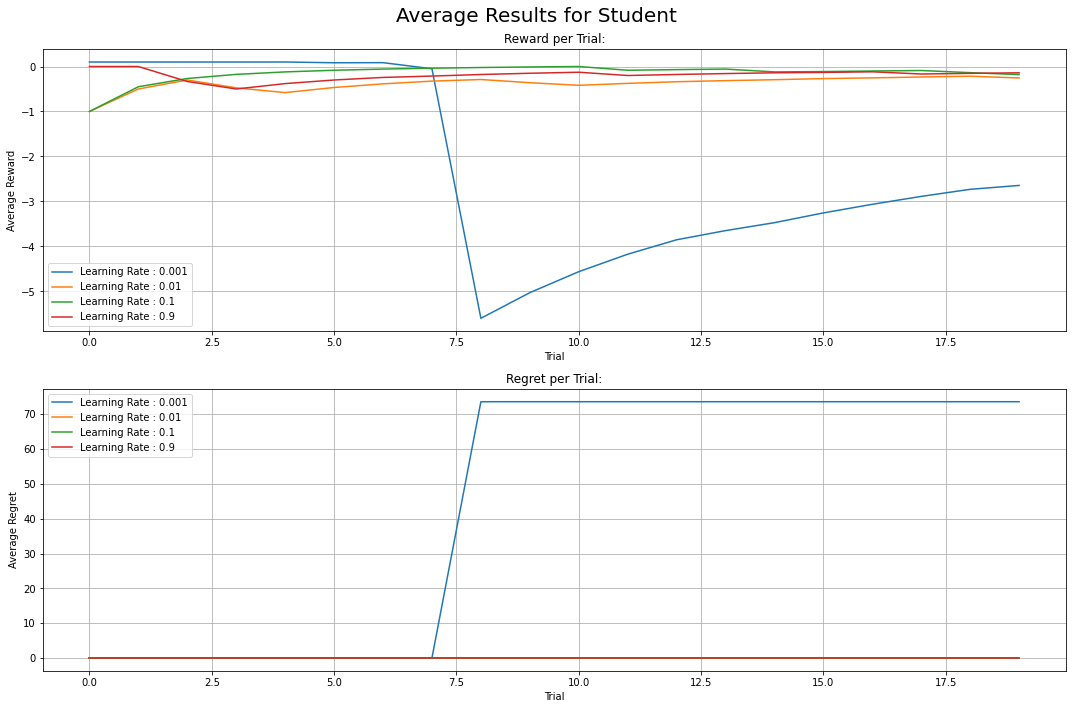

In [121]:
reward=Student()
env = Environment(reward=reward)

rewards=[]
regrets=[]
learning_rate = [1e-3,1e-2,1e-1,9e-1]
for j in range(4):
    agent =gradient(env=env,learning_rate=learning_rate[j])
    for i in range(1,21):
        agent.step(reward.best_reward,trial=i)
    rewards.append(np.cumsum(agent.get_rewards())/np.arange(1,21))
    regrets.append(np.cumsum(agent.get_regrets()))

fig,axs=plt.subplots(nrows=2,ncols=1,figsize=(15,10))
plt.suptitle("Average Results for Student",size=20)

axs[0].set_title('Reward per Trial:')
axs[0].set_ylabel("Average Reward")
axs[0].set_xlabel("Trial")
axs[0].grid()
for i in range(4):
    axs[0].plot(rewards[i],label=f'Learning Rate : {learning_rate[i]}')


for i in range(4):
    axs[1].plot(regrets[i],label=f'Learning Rate : {learning_rate[i]}')


axs[1].set_title('Regret per Trial:')
axs[1].set_ylabel("Average Regret")
axs[1].set_xlabel("Trial")
axs[1].grid()
axs[0].legend()
axs[1].legend()
fig.tight_layout()
plt.show()

In [124]:
agent.get_regrets()

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

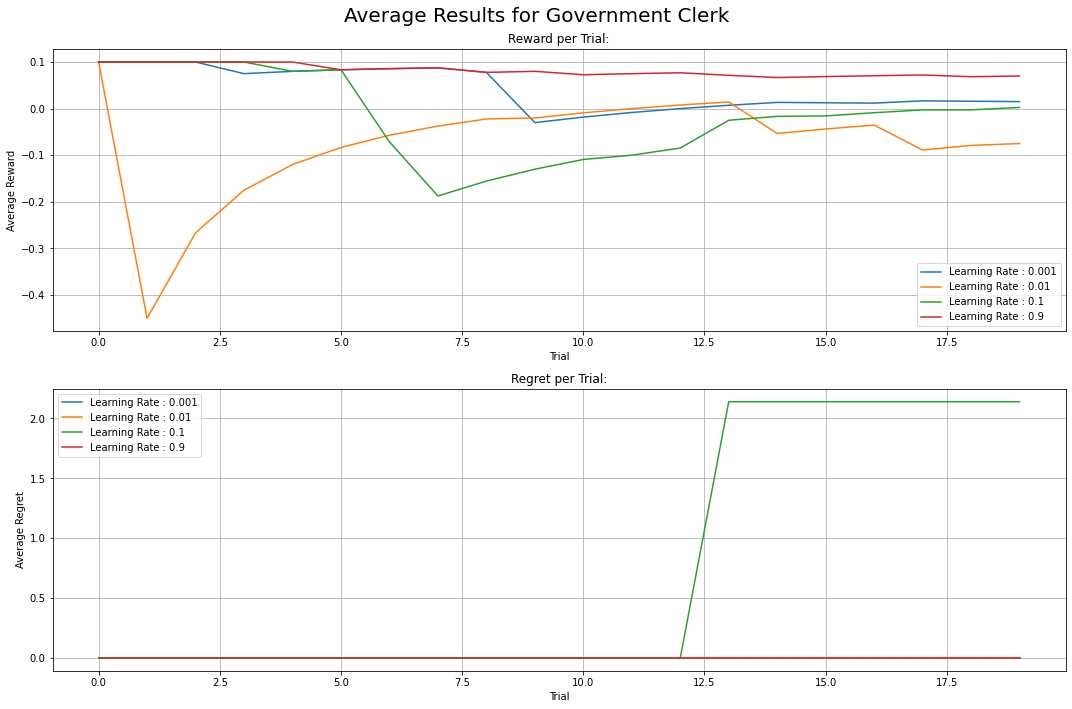

In [116]:
reward=GovStaff()
env = Environment(reward=reward)

rewards=[]
regrets=[]
learning_rate = [1e-3,1e-2,1e-1,9e-1]
for j in range(4):
    agent =gradient(env=env,learning_rate=learning_rate[j])
    for i in range(1,21):
        agent.step(reward.best_reward,trial=i)
    rewards.append(np.cumsum(agent.get_rewards())/np.arange(1,21))
    regrets.append(np.cumsum(agent.get_regrets()))

fig,axs=plt.subplots(nrows=2,ncols=1,figsize=(15,10))
plt.suptitle("Average Results for Government Clerk",size=20)

axs[0].set_title('Reward per Trial:')
axs[0].set_ylabel("Average Reward")
axs[0].set_xlabel("Trial")
axs[0].grid()
for i in range(4):
    axs[0].plot(rewards[i],label=f'Learning Rate : {learning_rate[i]}')


for i in range(4):
    axs[1].plot(regrets[i],label=f'Learning Rate : {learning_rate[i]}')


axs[1].set_title('Regret per Trial:')
axs[1].set_ylabel("Average Regret")
axs[1].set_xlabel("Trial")
axs[1].grid()
axs[0].legend()
axs[1].legend()
fig.tight_layout()
plt.show()

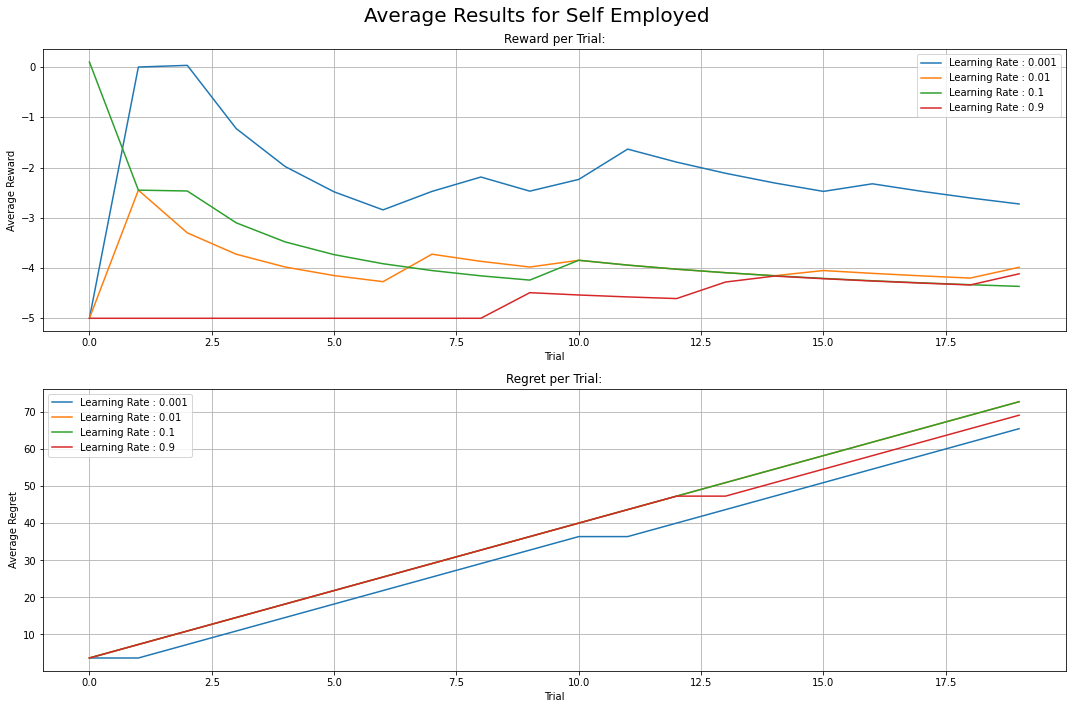

In [113]:
reward=SelfEmp()
env = Environment(reward=reward)

rewards=[]
regrets=[]
learning_rate = [1e-3,1e-2,1e-1,9e-1]
for j in range(4):
    agent =gradient(env=env,learning_rate=learning_rate[j])
    for i in range(1,21):
        agent.step(reward.best_reward,trial=i)
    rewards.append(np.cumsum(agent.get_rewards())/np.arange(1,21))
    regrets.append(np.cumsum(agent.get_regrets()))

fig,axs=plt.subplots(nrows=2,ncols=1,figsize=(15,10))
plt.suptitle("Average Results for Self Employed",size=20)

axs[0].set_title('Reward per Trial:')
axs[0].set_ylabel("Average Reward")
axs[0].set_xlabel("Trial")
axs[0].grid()
for i in range(4):
    axs[0].plot(rewards[i],label=f'Learning Rate : {learning_rate[i]}')


for i in range(4):
    axs[1].plot(regrets[i],label=f'Learning Rate : {learning_rate[i]}')


axs[1].set_title('Regret per Trial:')
axs[1].set_ylabel("Average Regret")
axs[1].set_xlabel("Trial")
axs[1].grid()
axs[0].legend()
axs[1].legend()
fig.tight_layout()
plt.show()